In [107]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [108]:
# Based on http://nghiaho.com/uploads/code/videostab.cpp

# The larger this value, the more stable the video but less reactive to sudden panning; in frames:
WINDOW_SIZE = 400
# 3 values for dx, dy, dangle
N_MEASURES = 3

In [109]:
def box_filter_convolve(y, window_size):
    # [n_frames, ]
    box_filter = np.ones(window_size)/window_size
    y_pad = np.lib.pad(y, (window_size, window_size), 'edge')
    y_smooth = np.convolve(y_pad, box_filter, mode='same')
    y_smooth = y_smooth[window_size:-window_size]
    assert y.shape == y_smooth.shape, print(y.shape, y_smooth.shape)
    return y_smooth

In [110]:
def before_after(trajectory, smoothed_trajectory):
    x = range(trajectory.shape[0])

    y1 = trajectory[:,0]
    y2 = smoothed_trajectory[:,0]
    plt.figure(figsize=(10, 5))
    plt.plot(x, y1, 'r')
    plt.plot(x, y2, 'b')

    y1 = trajectory[:,1]
    y2 = smoothed_trajectory[:,1]
    plt.figure(figsize=(10, 5))
    plt.plot(x, y1, 'r')
    plt.plot(x, y2, 'b')

In [111]:
def stabilize(in_path, out_path):
    cap = cv2.VideoCapture(in_path)

    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MJPG') # If error occurs, test other combos of fourcc and out_path extension
    out = cv2.VideoWriter(out_path, fourcc, fps, (w, h))

    frame_transforms = np.zeros((n_frames-1, N_MEASURES), np.float32)
    _, prev = cap.read()
    prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
    for i in range(n_frames-2):
        prev_pts = cv2.goodFeaturesToTrack(prev_gray,
                                           maxCorners=200,
                                           qualityLevel=0.01,
                                           minDistance=30,
                                           blockSize=3)

        _, curr = cap.read()
        curr_gray = cv2.cvtColor(curr, cv2.COLOR_BGR2GRAY)

        # Default settings
        curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None)

        assert prev_pts.shape == curr_pts.shape

        # Take only valid points
        id_ = np.where(status==1)[0]
        _prev_pts = prev_pts[id_]
        _curr_pts = curr_pts[id_]

        m = cv2.estimateAffinePartial2D(_prev_pts, _curr_pts)[0]

        dx = m[0,2]
        dy = m[1,2]
        dangle = np.arctan2(m[1,0], m[0,0])

        frame_transforms[i] = [dx,dy,dangle]

        prev_gray = curr_gray

    trajectory = np.cumsum(frame_transforms, axis=0)

    smoothed_trajectory = np.copy(trajectory)
    for i in range(N_MEASURES):
        smoothed_trajectory[:,i] = box_filter_convolve(trajectory[:,i], window_size=WINDOW_SIZE)

    diff = smoothed_trajectory - trajectory
    frame_transforms_fixed = frame_transforms + diff

    cap.set(cv2.CAP_PROP_POS_FRAMES, 0) # Write original version of first frame
    
    _, frame = cap.read()
    out.write(frame)
    
    # Write transformed n_frames-1:
    for i in range(n_frames-2):
        _, frame = cap.read()
        
        dx = frame_transforms_fixed[i,0]
        dy = frame_transforms_fixed[i,1]
        dangle = frame_transforms_fixed[i,2]

        m = np.zeros((2,3), np.float32)
        m[0,0] = np.cos(dangle)
        m[0,1] = -np.sin(dangle)
        m[1,0] = np.sin(dangle)
        m[1,1] = np.cos(dangle)
        m[0,2] = dx
        m[1,2] = dy
        
        frame_tr = cv2.warpAffine(frame, m, (w,h))
        out.write(frame_tr)

    out.release()
    cap.release()
    before_after(trajectory, smoothed_trajectory)

In [113]:
input_video_filepath = './339SD_O__S1_2.mp4'
output_video_filepath = './339SD_O__S1_2_stable_v2.mp4'

[ WARN:0@232080.707] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@232080.707] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin28 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@232080.707] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@232080.707] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/

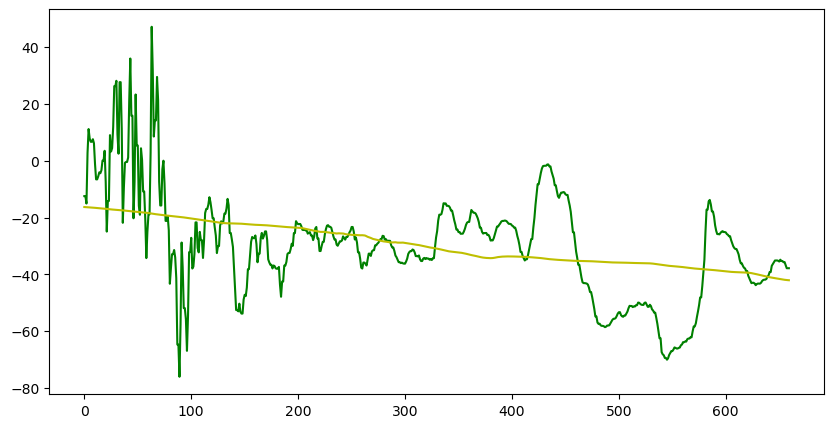

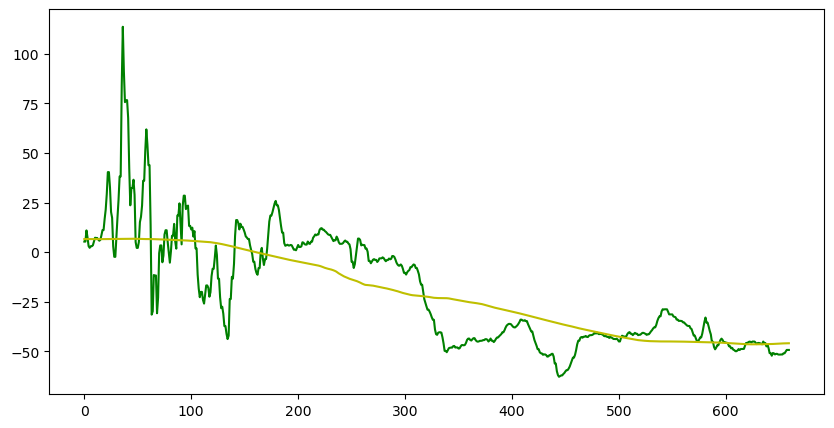

In [114]:
stabilize_video(input_video_filepath, output_video_filepath)